<a href="https://colab.research.google.com/github/janlucasdeinhard/pyfiles/blob/master/10_PROJECT_TIMESERIES/ReinforcementLearning/BASELINE_REINFORCE_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,warnings,datetime,time,sys,itertools,math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import gym

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.in0 = nn.Linear(4,10)
        self.out0 = nn.Linear(10,2)
    def forward(self,x):
        x = F.relu(self.in0(x))
        x = F.softmax(self.out0(x))
        return x

In [ ]:
def play_epsiode(env,model,deliver_results=False,verbose=False):
  s_c = env.reset()
  action_space = np.arange(env.action_space.n)
  states = []
  rewards = []    
  actions = []
  done = False
  ctr = 1
  while not done:
    action_probs = M.forward(torch.from_numpy(s_c).float()).detach().numpy()
    a_c = rnd.choice(action_space,p=action_probs)
    s_c,reward,done,info = env.step(a_c)
    states.append(s_c)
    rewards.append(reward)
    actions.append(action_probs)
    if ctr%1==0 and verbose: print('\tStep {0} -> Status done = {1}, rolling rewards = {2}'.format(ctr,done,np.mean(rewards)))
    ctr += 1
  if deliver_results: print('Terminated after {0} steps!'.format(ctr))
  return np.array(states),np.array(rewards),ctr

In [ ]:
def play_games(model,env,num_games=100):
  states = np.array([])
  training_rewards = np.array([])

  total_rewards = []
  for k in range(num_games):
    env.reset()
    c_s,c_r,num_steps = play_epsiode(env,model)
    c_train_rewards = np.array([(np.cumsum(c_r)[::-1][k]*0.8**k)-1 for k in range(np.cumsum(c_r)[::-1].shape[0])])
    states = np.append(states,c_s).reshape(-1,c_s.shape[1])
    training_rewards = np.append(training_rewards,c_train_rewards,axis=0)
    total_rewards.append(num_steps)
  return states,training_rewards,total_rewards

In [ ]:
def train_model(model,states,training_rewards):
  optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
  loss = []
  for k in range(training_rewards.shape[0]):
    logprobs = torch.FloatTensor(training_rewards[k].reshape(-1,1)) * model.forward(torch.FloatTensor(states[k,:]))
    c_loss = logprobs.mean()
    loss.append(c_loss.detach().numpy())
    optimizer.zero_grad()
    c_loss.backward()
    optimizer.step()
  return loss

In [ ]:
def test_model(model,env,num_steps=100):
  test_steps = []
  for k in range(num_steps):
    env.reset()
    _,_,c_steps = play_epsiode(env,model)
    test_steps.append(c_steps)
  return test_steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Reached step 0


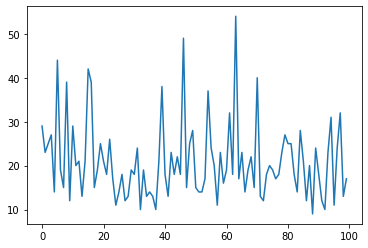

Reached step 4


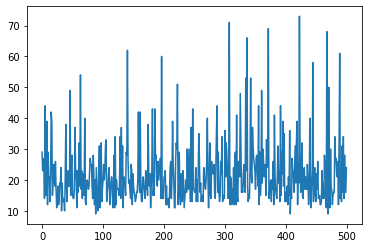

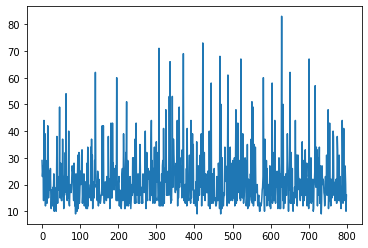

In [ ]:
M = Model()
env = gym.make('CartPole-v1')

test_loss = []

test_loss += test_model(M,env,num_steps=100)

for k in range(7):
  if k%4==0: 
    print('Reached step {0}'.format(k))
    plt.plot(test_loss)
    plt.show()
  states,training_rewards,steps = play_games(M,env,num_games=1000)
  loss = train_model(M,states,training_rewards)
  test_loss += test_model(M,env,num_steps=100)

plt.plot(test_loss)
plt.show()

In [ ]:
env.close()